In [142]:
suppressPackageStartupMessages({

library(admixr)
library(tidyverse)
library(forcats)
library(ggrepel)
library(glue)
library(future)

plan(multicore)

source("../code/utils.R")

})

In [93]:
nea_est <- readRDS("../paper/rds/f4_nea.rds") %>% filter(stat == "direct_f4", C == "Dinka") %>% mutate(X = str_replace(X, "UstIshim", "new_UstIshim") %>% str_replace("Loschbour", "new_Loschbour"))

In [143]:
samples <- load_samples()

Warning message:
“Missing column names filled in: 'X12' [12], 'X13' [13], 'X14' [14], 'X15' [15], 'X16' [16], 'X17' [17], 'X18' [18], 'X19' [19], 'X20' [20], 'X21' [21], 'X22' [22], 'X23' [23], 'X24' [24]”

In [144]:
samples %<>% filter(!pop %in% c("Africa", "Oceania"))

In [145]:
EIGENSTRAT_DIR <- "../data/eigenstrat/"

In [146]:
whole_gen %<-% qpF4ratio(X=c(filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name,
                             "new_UstIshim", "new_Loschbour"),
                    A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
                       prefix=paste0(EIGENSTRAT_DIR, "whole_genome/whole_genome"))

In [14]:
whole_gen <- mutate(whole_gen, X = case_when(X == "new_UstIshim" ~ "UstIshim",
                                             X == "new_Loschbour" ~ "Loschbour",
                                             TRUE ~ X))

In [49]:
whole_gen <- mutate(whole_gen, X = case_when(X == "UstIshim" ~ "new_UstIshim",
                                             X == "Loschbour" ~ "new_Loschbour",
                                             TRUE ~ X))

In [147]:
qiaomei_snps %<-% qpF4ratio(X=c(filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name,
                                "UstIshim", "Loschbour", "new_UstIshim", "new_Loschbour"),
                  A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
                  prefix=paste0(EIGENSTRAT_DIR, "bigyri_ho/all"))

In [151]:
bind_rows(mutate(qiaomei_snps, data="Q"), mutate(whole_gen, data="whole genome"),
         mutate(vcf_snps, data="VCF subset")) %>%
    filter(str_detect(X, "UstIshim|Loschbour")) %>% select(X, alpha, data)

X,alpha,data
UstIshim,0.025326,Q
Loschbour,0.024653,Q
new_UstIshim,0.048182,Q
new_Loschbour,0.047206,Q
new_UstIshim,0.028844,whole genome
new_Loschbour,0.025595,whole genome
new_UstIshim,0.022828,VCF subset
new_Loschbour,0.022026,VCF subset


## f4-ratios on Steffi's VCF processing vs Qiaomei's data

In [149]:
vcf_snps %<-% qpF4ratio(X=c(filter(samples, pop %in% c("WestEurasia", "EastAsia"))$name, "new_UstIshim", "new_Loschbour"),
                  A="new_Altai", B="new_Vindija", C="Dinka", O="Chimp",
                  prefix=paste0(EIGENSTRAT_DIR, "whole_genome/2.2M"))

Warning message in qt((1 - level)/2, df):
“NaNs produced”

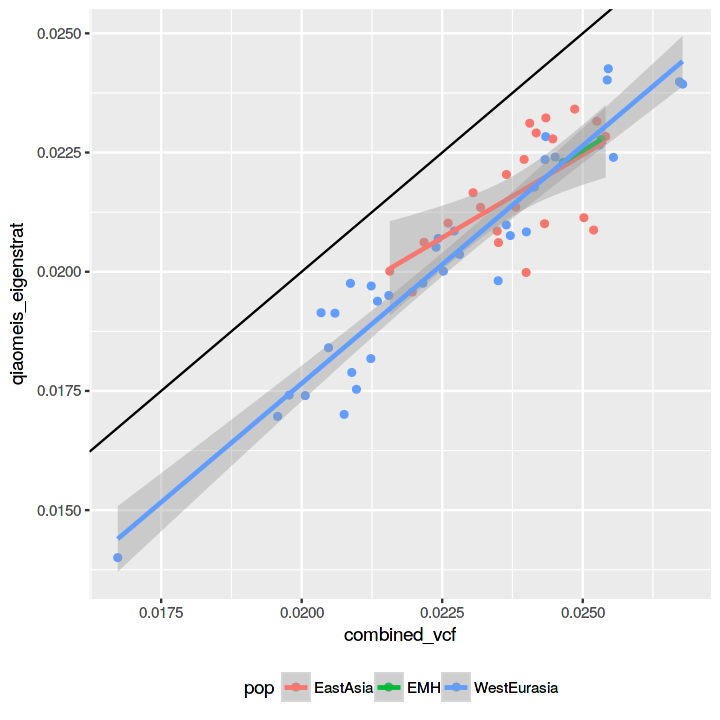

In [31]:
options(repr.plot.width = 6, repr.plot.height = 6)

inner_join(filter(qiaomei_snps, !str_detect(X, "new_UstIshim|new_Loschbour")) %>%
           mutate(X = case_when(X == "UstIshim" ~ "new_UstIshim",
                                X == "Loschbour" ~ "new_Loschbour",
                                TRUE ~ X)), vcf_snps, by = "X") %>%
    rename(combined_vcf = alpha.x, qiaomeis_eigenstrat = alpha.y) %>%
    inner_join(samples, by = c("X" = "name")) %>%
ggplot(aes(combined_vcf, qiaomeis_eigenstrat, color = pop)) +
    geom_point() +
    geom_abline(slope = 1) +
    geom_smooth(method = "lm") + theme(legend.position = "bottom")

In [161]:
near_east <- c("BedouinB", "Yemenite_Jew", "Palestinian", "Iraqi_Jew", "Jordanian",
               "Druze", "Iranian", "Samaritan")

In [170]:
combine_arrays <- function(set, statistic) {
    inner_join(
        #vcf_snps %>% select(X, array_alpha = alpha),
        #filter(qiaomei_snps, !str_detect(X, "new_UstIshim|new_Loschbour")) %>%
        #   mutate(X = case_when(X == "UstIshim" ~ "new_UstIshim",
        #                        X == "Loschbour" ~ "new_Loschbour",
        #                        TRUE ~ X)) %>% select(X, array_alpha = alpha),
        filter(nea_est, sites == set) %>% select(X, array_alpha = alpha),
        select(whole_gen, X, all_alpha = alpha),
    by = "X") %>%
        inner_join(samples, by = c("X" = "name"))
}

plot_corr <- function(set, statistic) {
    df <- combine_arrays(set, statistic)
    lm_res <- lm(all_alpha ~ array_alpha, data = filter(df, pop == "WestEurasia"))
    df %>%
    ggplot(aes(x = array_alpha, y = all_alpha, shape = X %in% near_east, color = pop)) +
        geom_point() +
        geom_smooth(method = "lm", aes(group = pop)) +
        geom_abline(slope = 1) +
        #geom_text_repel(aes(label = X), box.padding = 0.35, point.padding = 1) +
        ggtitle(glue("array sites: {set};  statistic:  {statistic}"),
                glue("R^2 = {summary(lm_res)$r.squared}, p-value = {summary(lm_res)$coefficients[2, 4] }")) +
        theme(legend.position = "bottom")
}

Warning message in qt((1 - level)/2, df):
“NaNs produced”Warning message in qt((1 - level)/2, df):
“NaNs produced”

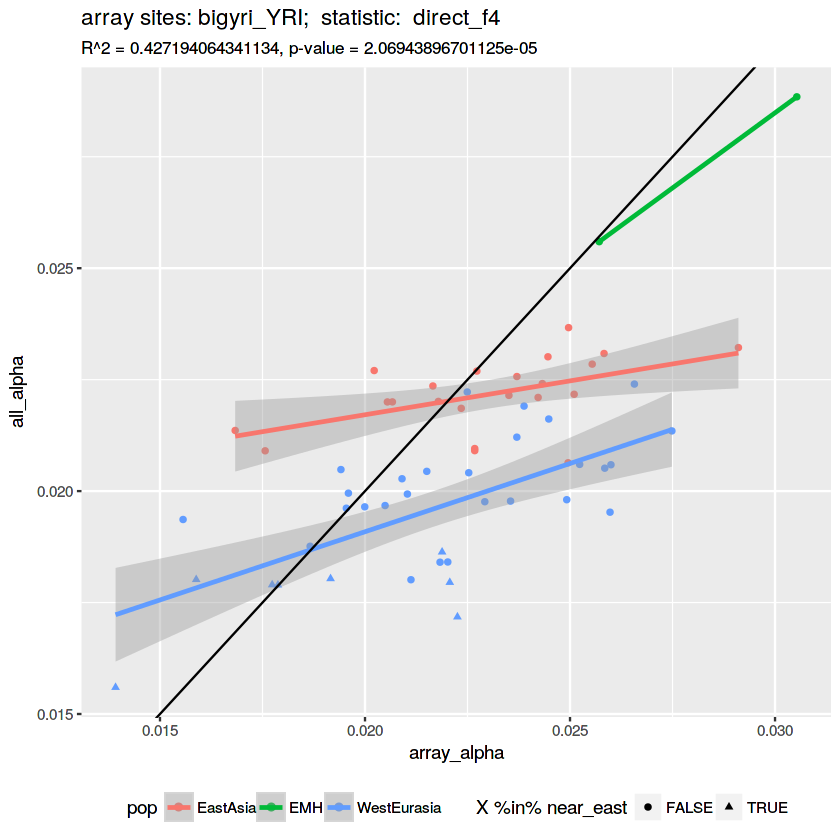

Warning message in qt((1 - level)/2, df):
“NaNs produced”

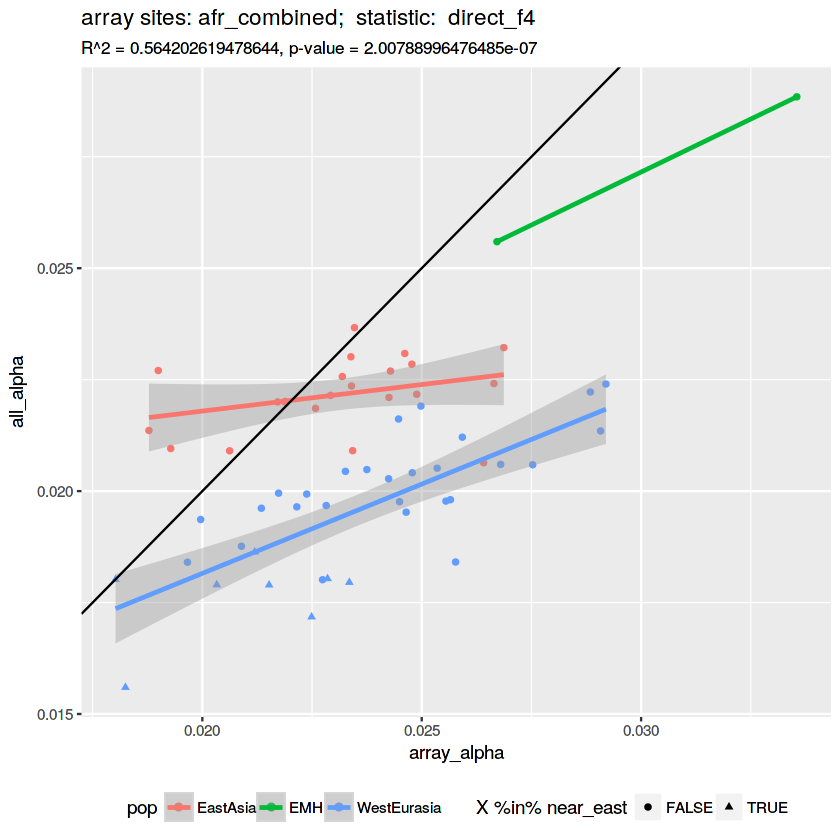

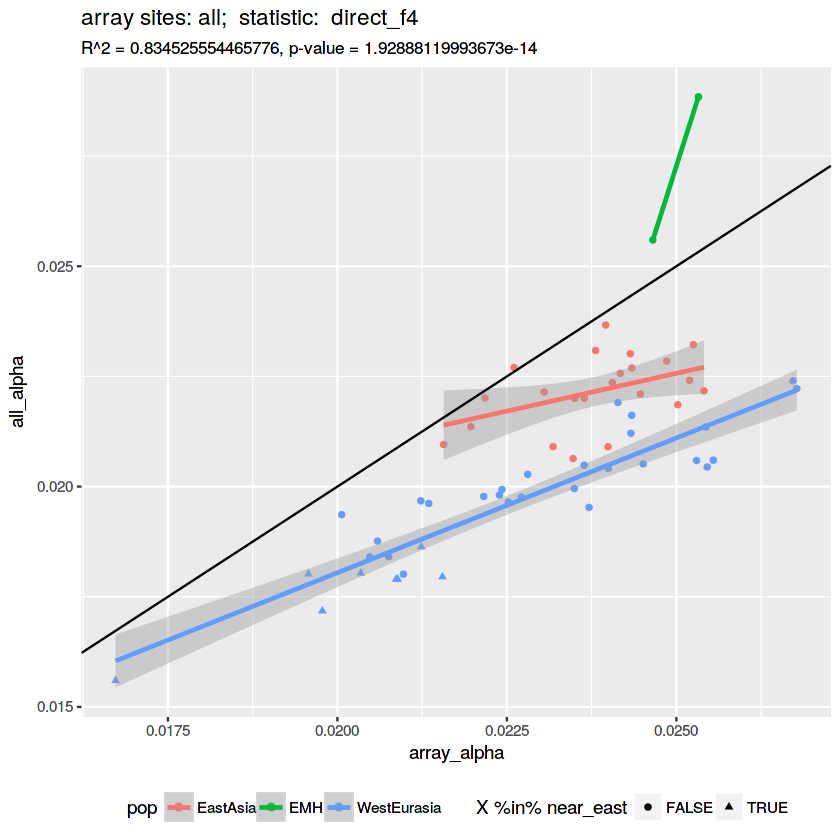

In [171]:
options(repr.plot.width = 7, repr.plot.height = 7)

for (set in c("bigyri_YRI", "afr_combined", "all")) {
    print(plot_corr(set, "direct_f4"))
}

Warning message in qt((1 - level)/2, df):
“NaNs produced”

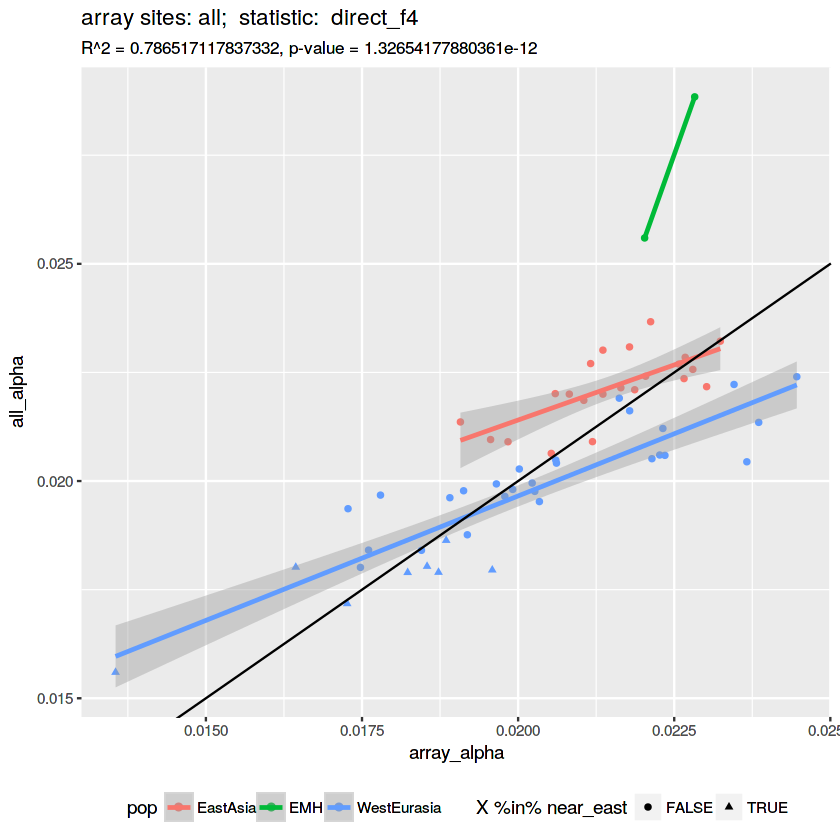

In [169]:
options(repr.plot.width = 7, repr.plot.height = 7)

for (set in c("all")) {
    print(plot_corr(set, "direct_f4"))
}

### whole genome

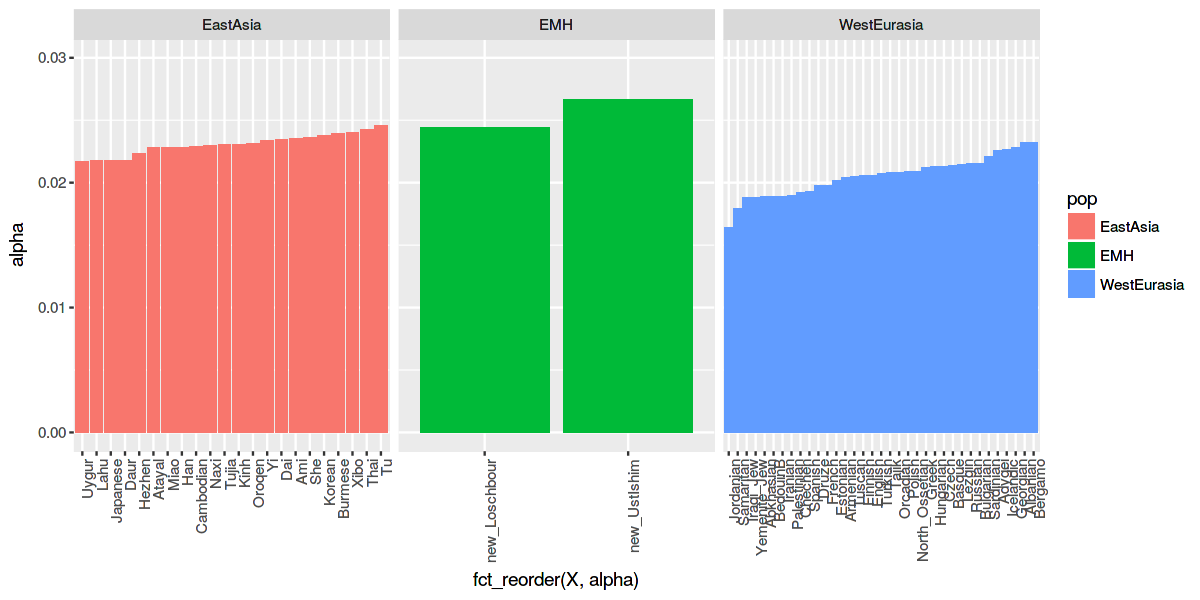

In [51]:
options(repr.plot.width=10, repr.plot.height=5)

inner_join(whole_gen, samples, by = c("X" = "name"))  %>%
ggplot(aes(fct_reorder(X, alpha), alpha, fill = pop)) + geom_bar(stat = "identity") + facet_wrap(~ pop, scales = "free_x") +
    theme(axis.text.x = element_text(hjust = 1, angle = 90)) + ylim(0, 0.03)

In [37]:
inner_join(whole_gen, samples, by = c("X" = "name"))  %>%
group_by(pop) %>% summarise(mean(alpha))

pop,mean(alpha)
EastAsia,0.02306918
EMH,0.02553100
WestEurasia,0.02052711


In [234]:
0.02306918/ 0.02052711

[1] 1.12384

### VCF subset

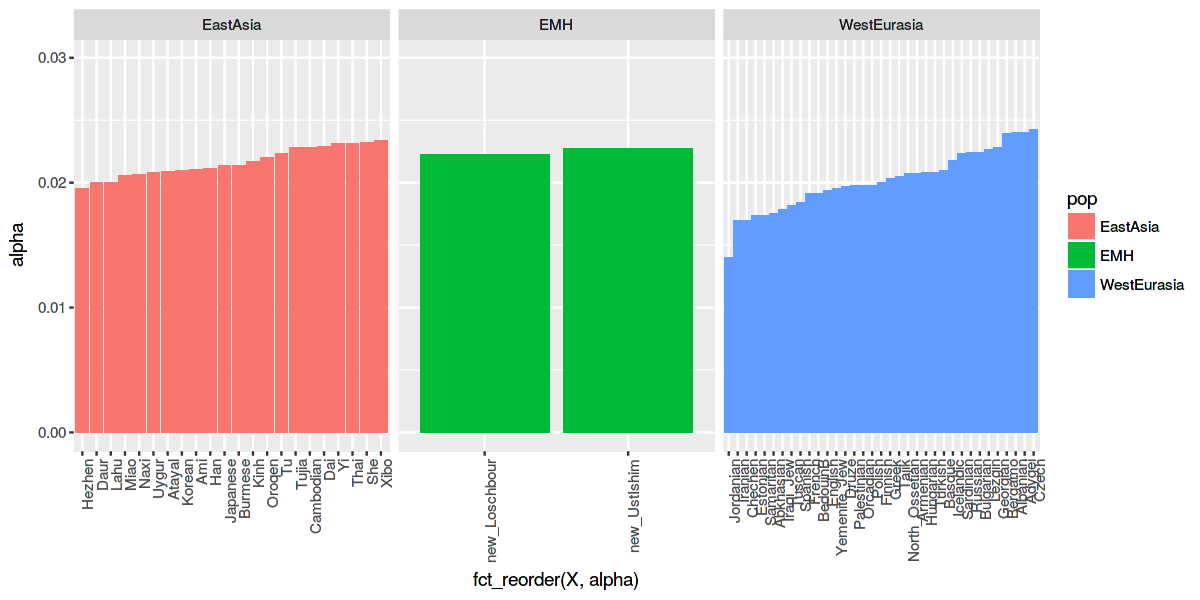

In [67]:
options(repr.plot.width=10, repr.plot.height=5)

inner_join(vcf_snps, samples, by = c("X" = "name"))  %>%
ggplot(aes(fct_reorder(X, alpha), alpha, fill = pop)) + geom_bar(stat = "identity") + facet_wrap(~ pop, scales = "free_x") +
    theme(axis.text.x = element_text(hjust = 1, angle = 90)) + ylim(0, 0.03)

In [68]:
inner_join(vcf_snps, samples, by = c("X" = "name"))  %>%
group_by(pop) %>% summarise(mean(alpha))

pop,mean(alpha)
EastAsia,0.02163086
EMH,0.02253250
WestEurasia,0.02018886


In [69]:
0.02163086/ 0.02018886

[1] 1.071426

### Qiaomei data

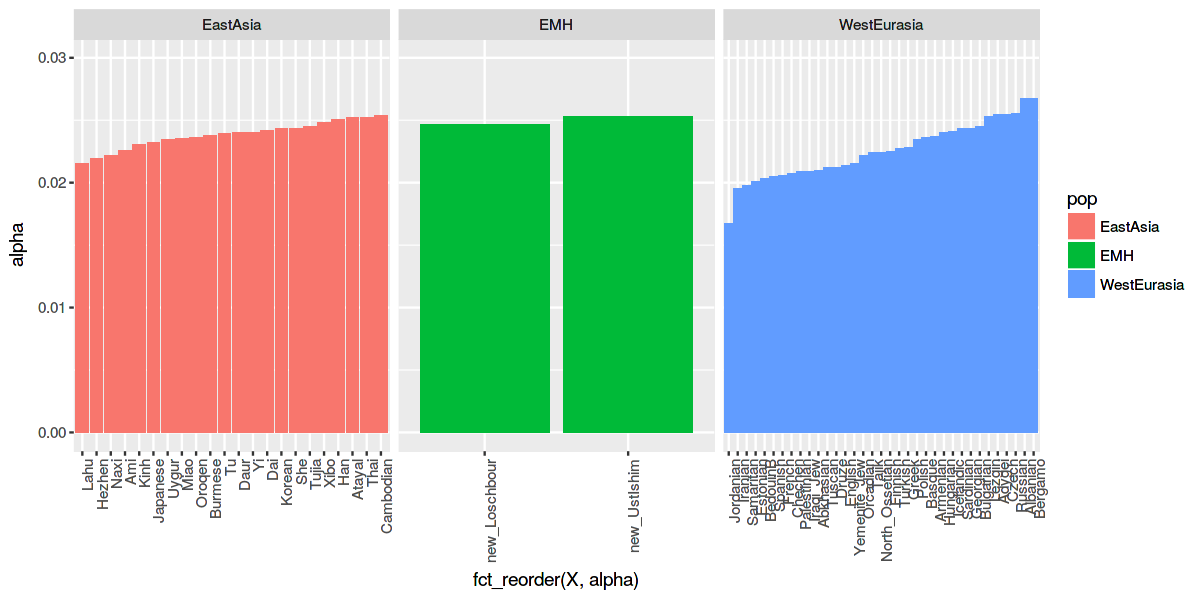

In [80]:
options(repr.plot.width=10, repr.plot.height=5)

filter(qiaomei_snps, !str_detect(X, "new_UstIshim|new_Loschbour")) %>%
mutate(X = case_when(X == "UstIshim" ~ "new_UstIshim",
                     X == "Loschbour" ~ "new_Loschbour",
                     TRUE ~ X)) %>% 
inner_join(samples, by = c("X" = "name"))  %>%
ggplot(aes(fct_reorder(X, alpha), alpha, fill = pop)) + geom_bar(stat = "identity") +
    facet_wrap(~ pop, scales = "free_x") +
    theme(axis.text.x = element_text(hjust = 1, angle = 90)) + ylim(0, 0.03)

In [81]:
inner_join(qiaomei_snps, samples, by = c("X" = "name"))  %>%
group_by(pop) %>% summarise(mean(alpha))

pop,mean(alpha)
EastAsia,0.02381918
EMH,0.04769400
WestEurasia,0.02253769


In [82]:
0.02381918/ 0.02253769

[1] 1.05686